![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 034</p>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">033_expの結果解析</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [27]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")
sys.path.append("../src/utils/pyspellchecker")

In [28]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from ast import literal_eval
from nltk.tokenize import TweetTokenizer
import spacy
from scipy.stats import sem
from copy import deepcopy
from spellchecker import SpellChecker
from typing import Text, Set, List


In [29]:
import torch

config = {
    "exp_comment":"Jigsaw-Classification をHateBERTで学習",
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "034_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": True,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 8,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "GroNLP/hateBERT",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MSELoss",
}

config = Box(config)
config.tokenizer = AutoTokenizer.from_pretrained(config.backbone.name)
config.model = BertForMaskedLM.from_pretrained(config.backbone.name)
# pprint(config)

In [30]:
config.tokenizer.save_pretrained(f"../data/processed/{config.backbone.name}")

pretrain_model = BertForMaskedLM.from_pretrained(config.backbone.name)
pretrain_model.save_pretrained(f"../data/processed/{config.backbone.name}")

In [31]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/034_exp
OUTPUT_DIR is ../data/interim/034_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [32]:
# Seed固定
seed_everything(config.seed)

42

In [33]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [34]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [35]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    033_exp 解析
</h2>
<br>

In [36]:
oof_df = pd.read_csv("../data/external/031_exp__oof.csv")
oof_df.head()

,worker,less_toxic,more_toxic,Rank__less__ToxicBERT__Ruddit,Rank__more__ToxicBERT__Ruddit,Diff__ToxicBERT__Ruddit,Rank__less__RoBERTa_Base__Jigsaw_Unbiased,Rank__more__RoBERTa_Base__Jigsaw_Unbiased,Diff__RoBERTa_Base__Jigsaw_Unbiased,Rank__less__DeBERTa_Base__Jigsaw_Unbiased,...,Diff_Rank__mul_xlmroberta_mean,Rank__ori_albert_mean__less,Rank__ori_albert_mean__more,Diff_Rank__ori_albert_mean,Rank__unb_albert_mean__less,Rank__unb_albert_mean__more,Diff_Rank__unb_albert_mean,Rank__Less__Ensemble,Rank__more__Ensemble,Diff__Ensemble
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,10793,4862,-5931,9071,9871,800,8895,...,-469,10383,9528,-855,8970,1071,-7899,9200.000000,8243.166667,-956.833333
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,2471,9550,7079,666,11089,10423,2013,...,8936,1830,9422,7592,2645,11898,9253,2010.250000,9675.833333,7665.583333
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",8100,8049,-51,8055,9134,1079,8011,...,-535,3773,3651,-122,6248,8672,2424,6828.166667,7113.666667,285.500000
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,9296,13474,4178,7319,13711,6392,6376,...,4820,8475,13309,4834,3809,14126,10317,8208.166667,13103.583333,4895.416667
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",9468,416,-9052,12294,9974,-2320,12166,...,-1114,10779,9605,-1174,11595,9705,-1890,10584.916667,9678.083333,-906.833333


In [44]:
oof_df = pd.concat(
    [oof_df, ohashi_lstm_df["Diff__ohashi_lstm"]],
    axis=1
)

In [45]:
diff_cols = [col for col in oof_df.columns.tolist() if "Diff__" in col]
print(diff_cols)

['Diff__ToxicBERT__Ruddit', 'Diff__RoBERTa_Base__Jigsaw_Unbiased', 'Diff__DeBERTa_Base__Jigsaw_Unbiased', 'Diff__Luke_Base__Wiki_Attack', 'Diff__TFIDF_Ridge__WikiAttack', 'Diff__TFIDF_Ridge__Jigsaw_classification', 'Diff__TFIDF_Ridge__Ruddit', 'Diff__Ensemble', 'Diff__ohashi_lstm']


In [46]:
for col in diff_cols:
    
    tmp_score = oof_df[oof_df[col]>0][col].count()/len(oof_df)
    print(f"{col} Score: {tmp_score:.6f}")

Diff__ToxicBERT__Ruddit Score: 0.647270
Diff__RoBERTa_Base__Jigsaw_Unbiased Score: 0.697124
Diff__DeBERTa_Base__Jigsaw_Unbiased Score: 0.698585
Diff__Luke_Base__Wiki_Attack Score: 0.687126
Diff__TFIDF_Ridge__WikiAttack Score: 0.678956
Diff__TFIDF_Ridge__Jigsaw_classification Score: 0.689053
Diff__TFIDF_Ridge__Ruddit Score: 0.632490
Diff__Ensemble Score: 0.708749
Diff__ohashi_lstm Score: 0.685034


In [24]:
worst_idx_list = oof_df.sort_values("Diff__Ensemble")[["worker", "less_toxic", "more_toxic", "Diff__Ensemble"]].head(20).index.tolist()


In [26]:
for idx in worst_idx_list:
    
    
    print(f"="*70)
    print(f"index is {idx}")
    print(f"-"*20, "less toxic", f"-"*20)
    print(oof_df.loc[idx, "less_toxic"])
    print(f"-"*20, "more toxic", f"-"*20)
    print(oof_df.loc[idx, "more_toxic"])
    print(f"="*70)


index is 25062
-------------------- less toxic --------------------
CaliforniaAliBaba is a Bitch
Go fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.
-------------------- more toxic --------------------
I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet.  Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.   
index is 15465
-------------------- less toxic --------------------
 lick my nuts 

you richard dawkins cock smoking asshole
-------------------- more toxic --------------------
Can you point those out? |heru|nar 
index is 20725
-------------------- less toxic --------------------
=why are you being so rude? i only want to help you motherfuckers. fuck! retards! you're suc

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Jigsaw Classification
</h2>
<br>

In [63]:
train_df = pd.read_csv("../data/external/jigsaw-classification/train.csv.zip")
display(train_df.head(10))
display(train_df.shape)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


(159571, 8)

In [64]:
train_df["is_colon"] = train_df["comment_text"].progress_apply(lambda x:1 if ":" in x else 0)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [65]:
def preprocess_text(txt:str) -> str:
    
    new_texts = txt
    new_texts = new_texts.replace(":", ",")
    
    return new_texts

In [66]:
train_df["text"] = train_df["comment_text"].progress_apply(preprocess_text)
test_df["text"] = test_df["text"].progress_apply(preprocess_text)
val_df["less_toxic"] = val_df["less_toxic"].progress_apply(preprocess_text)
val_df["more_toxic"] = val_df["more_toxic"].progress_apply(preprocess_text)

  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/7537 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

In [67]:
import re

spell = SpellChecker(distance=1)

def misspelt_words_fn(dataframe: pd.DataFrame) -> Set[Text]:
    misspelt_words = set()
    for tweet in dataframe['text'].str.casefold():
        [misspelt_words.add(word) for word in spell.unknown(tweet.split())]
    return misspelt_words

WORD = re.compile(r'\w+')
def reTokenize(tweet: Text) -> List[Text]:
    return WORD.findall(tweet.casefold())

PATTERN = re.compile(r"(.)\1{2,}")
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

def spell_correction(text: Text) -> Text:
    return ' '.join([spell.correction(word)
                     if word in misspelt_words else word
                     for word in reTokenize(reduce_lengthening(text))])


In [68]:
train_df["text"] = train_df["text"].progress_apply(spell_correction)
test_df["text"] = test_df["text"].progress_apply(spell_correction)
val_df["less_toxic"] = val_df["less_toxic"].progress_apply(spell_correction)
val_df["more_toxic"] = val_df["more_toxic"].progress_apply(spell_correction)

  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/7537 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

  0%|          | 0/30108 [00:00<?, ?it/s]

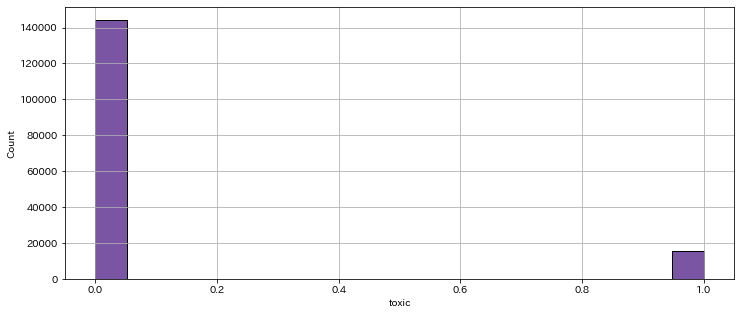

In [69]:
target_cols = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

plt.figure(figsize=(12, 5))
sns.histplot(train_df["toxic"], color="#4c1c84")
plt.grid()
plt.show()

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Pytorch Dataset
</h1>
<br>

In [70]:
class JigsawDataset:
    
    def __init__(self, df, tokenizer, max_length, mode, target_cols):
        
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.mode = mode
        self.target_cols = target_cols
        
        if self.mode == "train":
            self.text = df["text"].values
            self.target = df[target_cols].values
            
        elif self.mode == "valid":
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        else:
            self.text = df["text"].values
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            text = self.text[index]
            target = self.target[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        elif self.mode == "valid":
            
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_token_type_ids = inputs_less_toxic["token_type_ids"]
            
            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_token_type_ids': torch.tensor(more_token_type_ids, dtype=torch.long),
                
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_token_type_ids': torch.tensor(less_token_type_ids, dtype=torch.long),
                
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        else:
            
            text = self.text[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    DataModule
</h2>
<br>

In [71]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="train",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="valid",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="test",
            target_cols=target_cols
        )

        return DataLoader(dataset, **self._cfg.test_loader)

In [72]:
## DataCheck
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(train_df, val_df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [73]:
print(data["text_ids"].size())
print(data["text_mask"].size())
print(data["text_token_type_ids"].size())
print(data["target"].size())
print(data["target"])
output = config.model(
    data["text_ids"],
    data["text_mask"],
    data["text_token_type_ids"],
    output_hidden_states=True,
    output_attentions=True,
)
print(output["hidden_states"][-1].size(), output["attentions"][-1].size())
print(output["hidden_states"][-1][:, 0, :].size(), output["attentions"][-1].size())

torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 6])
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
torch.Size([8, 256, 768]) torch.Size([8, 12, 256, 256])
torch.Size([8, 768]) torch.Size([8, 12, 256, 256])


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    LigitningModule
</h2>
<br>

In [74]:
class JigsawModel(pl.LightningModule):
    
    def __init__(self, cfg, fold_num):
        
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = eval(self.cfg.loss)()
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num
        
    def __build_model(self):
        
        self.base_model = BertForMaskedLM.from_pretrained(
            self.cfg.backbone.name
        )
        print(f"Use Model: {self.cfg.backbone.name}")
        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Linear(768, self.cfg.backbone.output_dim)
        
    def forward(self, ids, mask, token_type_ids):
        
        output = self.base_model(
            input_ids=ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            output_attentions=True
        )
        feature = self.norm(output["hidden_states"][-1][:, 0, :])
        out = self.drop(feature)
        out = self.head(out)
        
        return {
            "logits":out, 
            "feature":feature,
            "attention":output["attentions"], 
            "mask":mask,
        }
    
    def training_step(self, batch, batch_idx):
        
        text_ids = batch["text_ids"]
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']
        
        outputs = self.forward(text_ids, text_mask, text_token_type_ids)
        loss = torch.sqrt(self.criterion(outputs["logits"], targets))
        
        return {
            "loss":loss,
            "targets":targets,
        }
    
    def training_epoch_end(self, training_step_outputs):

        loss_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        more_text_token_type_ids = batch['more_token_type_ids']
        
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        less_text_token_type_ids = batch['less_token_type_ids']
        
        targets = batch['target']

        more_outputs = self.forward(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids
        )
        
        less_outputs = self.forward(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        
        more_outputs = torch.sum(more_outputs["logits"], 1)
        less_outputs = torch.sum(less_outputs["logits"], 1)
        
        outputs = more_outputs - less_outputs
        logits = outputs.clone()

        logits[logits > 0] = 1
        loss = self.criterion(logits, targets)

        return {
            "loss":loss,
            "pred":outputs,
            "targets":targets,
        }
    
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"].detach().cpu().numpy())
            target_list.append(out["targets"].detach().cpu().numpy())

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        pred_count = sum(x>0 for x in pred_list)/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
            f"valid_acc/fold{self.fold_num+1}":pred_count,
        }

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Training
</h2>
<br>

In [77]:
skf = KFold(
    n_splits=config.n_fold, 
    shuffle=True, 
    random_state=config.seed
)

for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df["toxic"])):
    train_df.loc[val_idx, "kfold"] = int(fold)

train_df["kfold"] = train_df["kfold"].astype(int)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_colon,text,kfold
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,d aww he matches this background colour i m se...,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man i m really not trying to edit war it s...,3
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,more i can t make any real suggestions on impr...,2
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir are my hero any chance you remember wh...,0


In [78]:
## Debug
config.trainer.fast_dev_run = True
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['Hate-BERT', "Jigsaw-Classification"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.73it/s loss: 0.591 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.67it/s loss: 0.641 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.44it/s loss: 0.675 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 3.10it/s loss: 0.581 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.85it/s loss: 0.769 v_num:  

In [ ]:
## Training
config.trainer.fast_dev_run = False
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['Hate-BERT', "Jigsaw-Classification"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT


wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-01-27 09:12:16.260800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForMaskedLM │  109 M │
│ 1 │ norm       │ LayerNorm       │  1.5 K │
│ 2 │ drop       │ Dropout         │      0 │
│ 3 │ head       │ Linear          │  4.6 K │
│ 4 │ criterion  │ MSELoss         │      0 │
└───┴────────────┴─────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 438

Output()

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

MORE = np.zeros((len(val_df), config.backbone.output_dim))
LESS = np.zeros((len(val_df), config.backbone.output_dim))
PRED = np.zeros((len(test_df), config.backbone.output_dim))

attention_array = np.zeros((len(val_df), 256)) # attention格納
mask_array = np.zeros((len(val_df), 256)) # mask情報格納,後でattentionと掛け合わせる

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    valid_dataloader = JigsawDataModule(train_df, val_df, test_df, config).val_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    more_list = []
    less_list = []
    
    for step, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):

        more_toxic_ids = data['more_toxic_ids'].to(device)
        more_toxic_mask = data['more_toxic_mask'].to(device)
        more_text_token_type_ids = data['more_token_type_ids'].to(device)
        
        less_toxic_ids = data['less_toxic_ids'].to(device)
        less_toxic_mask = data['less_toxic_mask'].to(device)
        less_text_token_type_ids = data['less_token_type_ids'].to(device)
        
        more_outputs = model(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids,
        )
        
        less_outputs = model(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        more_list.append(more_outputs["logits"].detach().cpu().numpy())
        less_list.append(less_outputs["logits"].detach().cpu().numpy())

    MORE += np.concatenate(more_list)/len(config.train_fold)
    LESS += np.concatenate(less_list)/len(config.train_fold)
#     PRED += pred_list/len(config.train_fold)

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/3764 [00:00<?, ?it/s]

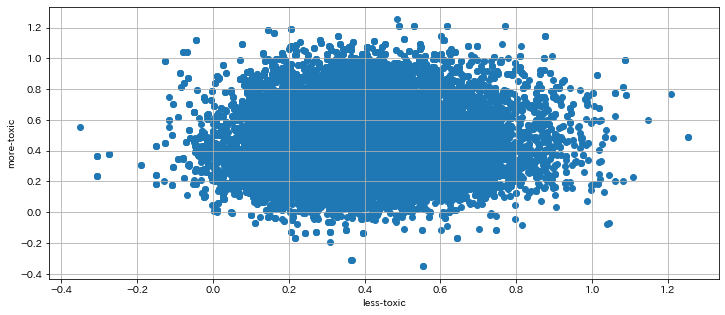

In [55]:
plt.figure(figsize=(12, 5))
plt.scatter(LESS, MORE)
plt.xlabel("less-toxic")
plt.ylabel("more-toxic")
plt.grid()
plt.show()

In [56]:
val_df["less_attack"] = LESS.sum(axis=1)
val_df["more_attack"] = MORE.sum(axis=1)
val_df["diff_attack"] = val_df["more_attack"] - val_df["less_attack"]
attack_score = val_df[val_df["diff_attack"]>0]["diff_attack"].count()/len(val_df)
print(f"Wiki Attack Score: {attack_score:.6f}")

Wiki Attack Score: 0.626345


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Attention Visualize
</h2>
<br>

In [57]:
text_df = pd.DataFrame()
text_df["text"] = list(set(val_df["less_toxic"].unique().tolist() + val_df["more_toxic"].unique().tolist()))

display(text_df.head())
display(text_df.shape)

,text
0,FUCK \n\nWhy hasn't anyone included this info...
1,"Come on, we've had enough of your fanatical ex..."
2,MONGO is a homosexual crybaby!
3,"The black album is certainly not thrash, nor a..."
4,The statement about which you were bitching


(14251, 1)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

attention_array = np.zeros((len(text_df), config.max_length)) # attention格納
mask_array = np.zeros((len(text_df), config.max_length)) # mask情報格納,後でattentionと掛け合わせる
feature_array = np.zeros((len(text_df), 768))
PRED = np.zeros((len(text_df), config.backbone.output_dim))

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    test_dataloader = JigsawDataModule(train_df, val_df, text_df, config).test_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    attention_list = []
    feature_list = []
    mask_list = []
    pred_list = []
    
    for step, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):

        text_ids = data["text_ids"].to(device)
        text_mask = data["text_mask"].to(device)
        text_token_type_ids = data["text_token_type_ids"].to(device)
        
        mask_list.append(text_mask.detach().cpu().numpy())
            
        outputs = model(
            text_ids, 
            text_mask,
            text_token_type_ids,
        )
        
        ## Last LayerのCLS Tokenに対するAttention
        last_attention = outputs["attention"][-1].detach().cpu().numpy()
        total_attention = np.zeros((last_attention.shape[0], config.max_length))
        
        for batch in range(last_attention.shape[0]):
            for n_head in range(12):
                total_attention[batch, :] += last_attention[batch, n_head, 0, :]
                
        attention_list.append(total_attention)
        pred_list.append(outputs["logits"].detach().cpu().numpy())
        feature_list.append(outputs["feature"].detach().cpu().numpy())

    attention_array += np.concatenate(attention_list)/config.n_fold
    mask_array += np.concatenate(mask_list)/config.n_fold
    feature_array += np.concatenate(feature_list)/config.n_fold
    PRED += np.concatenate(pred_list)/len(config.train_fold)
    
    

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: GroNLP/hateBERT
Use Model: GroNLP/hateBERT


  0%|          | 0/1782 [00:00<?, ?it/s]

In [59]:
text_df["target"] = PRED[:, 0]
text_df.to_pickle(OUTPUT_DIR/"text_df.pkl")
np.save(OUTPUT_DIR/'toxic-attention.npy', attention_array)
np.save(OUTPUT_DIR/'toxic-mask.npy', mask_array)
np.save(OUTPUT_DIR/'toxic-feature.npy', feature_array)

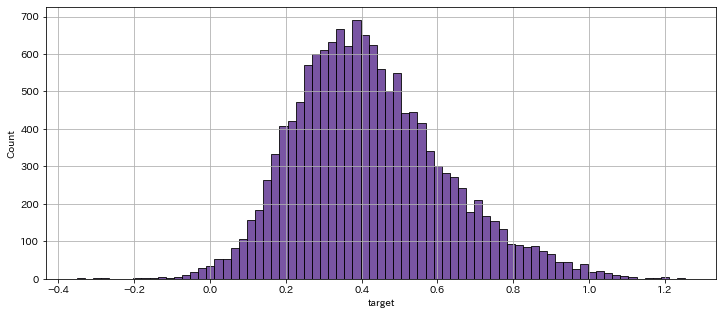

In [60]:
plt.figure(figsize=(12, 5))
sns.histplot(text_df["target"], color="#4c1c84")
plt.grid()
plt.show()

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Attention Load
</h2>
<br>

In [61]:
text_df = pd.read_pickle(OUTPUT_DIR/"text_df.pkl")
attention_array = np.load(OUTPUT_DIR/'toxic-attention.npy')
mask_array = np.load(OUTPUT_DIR/'toxic-mask.npy')

In [62]:
from IPython.display import display, HTML

def highlight_r(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

In [63]:
num = 12

ids = config.tokenizer(text_df.loc[num, "text"])["input_ids"]
tokens = config.tokenizer.convert_ids_to_tokens(ids)
attention = attention_array[num, :][np.nonzero(mask_array[num, :])]

html_outputs = []

for word, attn in zip(tokens, attention):
    html_outputs.append(highlight_r(word, attn))

print(f"Offensive Score is {PRED[num, 0]}")
display(HTML(' '.join(html_outputs)))
display(text_df.loc[num, "text"])

Offensive Score is 0.1531775863841176


" 2005 (UTC)\n\nWhat a load of shit. I see entries ALL THE TIME that have links which have nothing much to do with the entry in question. Also, the Fark thread IS DISCUSSING THE HURRICANE.  Therefore, it's valid.   06:47, 29 August"

In [64]:
text_df.sort_values("target", ascending=False).head(20)

,text,target
359,you bitchass trick\n\nyour fat ass is full of ...,1.253505
5925,Mine ur own fucking bussiness.wat da fuck is u...,1.209513
11655,Chanting Fox \n\nShut up you dumb cunt. Your ...,1.209113
4274,"YAMLA, are you stupid and a gay ass fag whos ...",1.207486
4165,Chanting Cox \n\nShut up you dumb cunt. Your ...,1.193007
9100,YOU GUYS ARE FUCKIN CRAZY YOU STUPID SHIT LICK...,1.181670
6876,HEEY FUCKFACE YOU ARE A REAL BITCH ASS PUSSY W...,1.162992
2730,closedmouth is a DICK-FUCK \n\nthis guy is a ...,1.146494
2268,DOUCHE BAG DOUCHE BAG DOUCHE BAG DOUCHE BAG FU...,1.123234
5082,is all pretty gay if u ask me...bunch or fucki...,1.119021


In [65]:
high_score_list = text_df.sort_values("target", ascending=False).head(20).index.tolist()

for num in high_score_list:
    
    ids = config.tokenizer(text_df.loc[num, "text"])["input_ids"]
    tokens = config.tokenizer.convert_ids_to_tokens(ids)
    attention = attention_array[num, :][np.nonzero(mask_array[num, :])]

    html_outputs = []

    for word, attn in zip(tokens, attention):
        html_outputs.append(highlight_r(word, attn))

    print(f"Offensive Score is {PRED[num, 0]}")
    display(HTML(' '.join(html_outputs)))
    display(text_df.loc[num, "text"])



Offensive Score is 1.2535049617290497


'you bitchass trick\n\nyour fat ass is full of dogshit,\n\ncommie loving, lying, bastardo chink.'

Offensive Score is 1.2095131427049637


'Mine ur own fucking bussiness.wat da fuck is ur problem u ugly fat ass motherfuck ].go suck on your moms dick and fuck ur dads pussy.u fat bitch.'

Offensive Score is 1.2091129273176193


' Chanting Fox \n\nShut up you dumb cunt. Your a nigger  loving, cum cuzzling crack whore bitch!'

Offensive Score is 1.2074861228466034


'YAMLA,  are you stupid and a gay ass fag whos mother was a fucking whore you fuking idiotical mongolical son of a bitch you are so fucking faaaaaaagggggggggggggyyyyyyyyyyyyyy that oyuy suck as much cock as your dad who was the biggest gay ass idiot in history who ever sucked cock and oyu also stuck up a dildo up your mothers ass while she was pooing and you made your sister eat that shit!!!!'

Offensive Score is 1.193007230758667


' Chanting Cox \n\nShut up you dumb cunt. Your a nigger  loving, cum cuzzling crack whore bitch!'

Offensive Score is 1.1816698163747787


"YOU GUYS ARE FUCKIN CRAZY YOU STUPID SHIT LICK YOUR OWN PIMPLY FAT UGLY BUM!!!! YOU ARE CRAZY YOU ALL GAYS AND FAGGOTS IF NOT MALE THAN LESBIAN I KNOW YOU GONNA DELETE ME OR DO YOUR STUPID BLOCK THING TO ME NOW BUT I DON'T CARE YOU ARE SINGLE AND HAVE THE WEIRDEST BOOBS OKAY I HATE YOU BITCHES!"

Offensive Score is 1.1629921793937683


'HEEY FUCKFACE YOU ARE A REAL BITCH ASS PUSSY WHIPPED MUTHAFUCKING FAGGOT SHITFACEd DICK HEAd '

Offensive Score is 1.1464938670396805


' closedmouth is a DICK-FUCK \n\nthis guy is a jackass who sux cock 4 a fuckin job y the fuck does the trans do it?????cuz its into tht kinda shit >:('

Offensive Score is 1.1232340037822723


'DOUCHE BAG DOUCHE BAG DOUCHE BAG DOUCHE BAG FUCKER FUCKER FUCKER FUCKER FUCKER COCK SHIT FUCK TITS BALLS WEINER. CLUEBOT IS A FAGGOT WHO LIKES TO GET CORNHOLED BY YOUNG BLACK STALLIONS 24/7 365......SUCK IT BITCH        REPPIN NEBRACKA BITCH...one love\nalright you fucking cluebot cock sucker dont be telling me i cant say whatever the fuck i want to on this goddammed website...freedom of speech bitch...put that in your fucking pipe and smoke it.'

Offensive Score is 1.1190205514431


"is all pretty gay if u ask me...bunch or fucking retards.\nYou are a wife beater/cunt slapper. That's right I called your wife a cunt. BITCHES!!!!"

Offensive Score is 1.1182697713375092


'YOUR A FUCKING FAGGOT YOU INTERNET THUG GET OFF FEDERLINES NUTS'

Offensive Score is 1.1097222417593002


'Fucking Faggot\n\nThis guy is a total fucking faggot'

Offensive Score is 1.1071379035711288


'Yes Ah soooBig Dumb Object, just a bunch o hosers, give up so easily..quitters'

Offensive Score is 1.1069359183311462


' how dare u you german piece of dog shit \n\ndont u fucking clear my edit ever again u piece of horse shit faggot'

Offensive Score is 1.0981042832136154


' Fuck you \nfred fuck you you bitch ass punk u can suck a dick deleting everything fuck you ho go to hell you dumbass. your a bitch you stupid ass motherfucker. put a big stick in your mouth and leave.'

Offensive Score is 1.0954248905181885


'you bunch of cock cucking, toilet scrubbing, tit licking, fanny kissing, arse wanking BASTARDS I HOPE YOU ALL ROT IN HELL ESPECIALLY GUY WALTERS'

Offensive Score is 1.0940985679626465


'Diana is a fucking bitch nigger piece of shit'

Offensive Score is 1.0937582701444626


'FUCK YOU, YOU GAY ASS LIBERAL!!!\nhey asshole why dont you get your face out of the fucking child molestes homepage and go fuck your self you gay ass liberal mother fucker i hate jews like you fuck you and your whole fucking family you fucking sand nigger lover'

Offensive Score is 1.0936612784862518


"Suck a Dick\nPussy Hoe Ass\nYa'll lame anyways\nAnd how you know what somebody doing?\nGet yo fake ass outta here bitch!!!"

Offensive Score is 1.0906627178192139


'Hey Man\nYou are a retarded Mexican cocksucking piece of fucking shit. Please go fucking kill yourself. Wikipedia admins are lower then niggers! Fuck you!  '